<div class="row">
    <div class="column">
        <img src="https://datasciencecampus.ons.gov.uk/wp-content/uploads/sites/10/2017/03/data-science-campus-logo-new.svg"
             alt="Data Science Campus Logo"
             align="right" 
             width = "340"
             style="margin: 0px 60px"
             />
    </div>
    <div class="column">
        <img src="https://cdn.ons.gov.uk/assets/images/ons-logo/v2/ons-logo.svg"
             alt="ONS Logo"
             align="left" 
             width = "420"
             style="margin: 0px 30px"/>
    </div>
</div>

# Working with Generalised Linear Models

This exercise aims to demonstrate the implementation of a count model using glms in python and statsmodels.

In [1]:
# Some imports.
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy.stats import poisson, nbinom, norm, chi2
%matplotlib inline

# Data Preparation

In [2]:
# Read in Data
bikes = pd.read_csv("./Data/Brooklyn_Bridge_Bicycle_Counts.csv")

# Make column names lowercase
bikes.columns = bikes.columns.str.lower()

### Generate some variables
# Make date a datetime variable
bikes['date'] = pd.to_datetime(bikes['date'], format = "%d-%b-%y")
# Make day of the week variable
bikes['day_of_week'] = bikes['date'].dt.weekday_name
# Make weekend variable
bikes['weekend'] = bikes['date'].dt.weekday > 4
# Make month variable
bikes['month'] = bikes['date'].dt.month_name()
# Convert fahrenheit to celsius
bikes['high_temp_C'] = (bikes['high_t'] - 32) * 5/9
bikes['low_temp_C'] = (bikes['low_t'] - 32) * 5/9
# drop fahrenheit variables
bikes = bikes.drop(columns = ['high_t', 'low_t'])

bikes.head()

,date,precip,bb_count,day_of_week,weekend,month,high_temp_C,low_temp_C
0,2017-04-01,0.00,606,Saturday,True,April,7.777778,2.777778
1,2017-04-02,0.00,2021,Sunday,True,April,16.722222,5.000000
2,2017-04-03,0.03,2470,Monday,False,April,17.222222,10.000000
3,2017-04-04,1.18,723,Tuesday,False,April,10.611111,7.777778
4,2017-04-05,0.00,2807,Wednesday,False,April,17.222222,7.777778


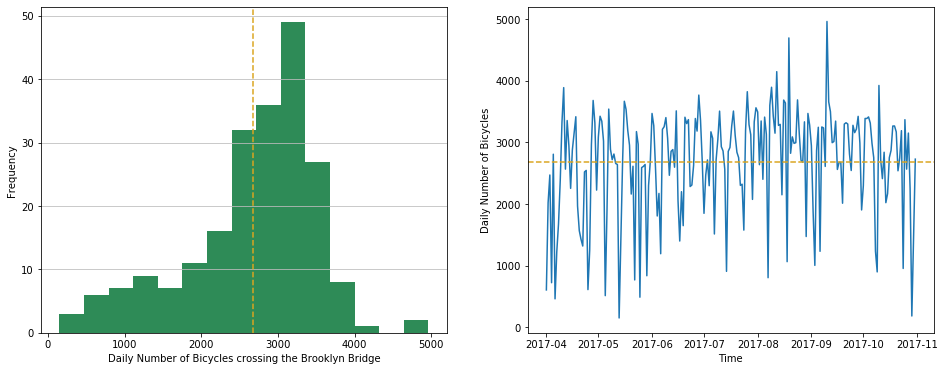

In [3]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))

# Total Histogram
ax1.hist(bikes['bb_count'],color='seagreen', bins = 15)
ax1.axvline(bikes['bb_count'].mean(), linestyle ='dashed', color = 'goldenrod')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Daily Number of Bicycles crossing the Brooklyn Bridge')
ax1.yaxis.grid(color='0.741')

# Time plot
ax2.plot(bikes['date'], bikes['bb_count'])
ax2.axhline(bikes['bb_count'].mean(), linestyle ='dashed', color = 'goldenrod')
ax2.set_ylabel("Daily Number of Bicycles")
ax2.set_xlabel("Time");

# Count Data

Count data are discrete data (i.e. integers) with non-negative values that count something, like the number of times an event occurs during a given time period. Our data are count data because they count the number of times that cyclists cross the Brooklyn Bridge between Brooklyn and Manhattan (or vice versa) in New York City on a given day.

Count data can also be expressed as rate data, since the number of times an event occurs in a time period can be expressed as a raw count. For instance, 2,400 cyclists crossed the Brooklyn Bridge in a day, or cyclists crossed the Brooklyn Bridge at a rate of 200 per hour.

Poisson regression can be used to analyse count data and rate data. It allows us to determine the explanatory variables that are associated with our given response variable (the count or a rate). Poisson regression can be applied to the Brooklyn Bridge data we have here to better understand and predict the how cyclists use the bridge.


## The Poisson Distribution

The Poisson distribution expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event. The Poisson distribution can also be used for the number of events in other specified intervals such as distance, area or volume.

The Poisson distribution is given by the formula:

$$P(k\ \mathrm{events}) = \frac{\lambda^{k}e^{-\lambda}}{k!} $$

Where, $\lambda$ is the average density of the events (e.g. cyclists per day), and the function returns the likelihood of seeing $k$ cyclists.

In some cases, such as in python, $\lambda$ (lambda) is refered to as $\mu$ (mu).

One of the most famous historical, practical uses of the Poisson distribution was estimating the annual number of Prussian cavalry soldiers killed due to horse-kicks.

For bicycle counts, it allows us to generate estimates for the number of cyclists crossing the Brooklyn Bridge on any given day:

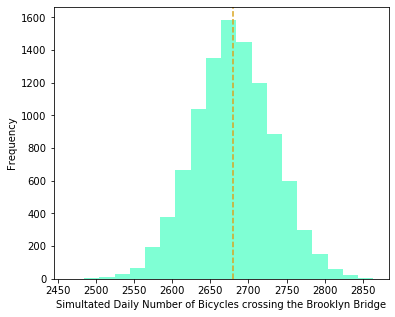

In [4]:
sim_counts = poisson.rvs(mu = 2680, size = 10000) # mu is mean cyclists per day, size is 10000 samples.

f, ax = plt.subplots(figsize = (6,5))
ax.hist(sim_counts, bins=20, color = 'aquamarine')
ax.axvline(sim_counts.mean(), linestyle ='dashed', color = 'goldenrod')
ax.set_ylabel('Frequency')
ax.set_xlabel('Simultated Daily Number of Bicycles crossing the Brooklyn Bridge');

At first glance this looks reasonable, we've drawn a peaked distribution around our chosen $\lambda$. However, look a bit closer and you'll see something is not right. The spread of the simulated poisson data doesn't seem to be any where near the spread of our actual data.

Notice that the Poisson distribution only has one parameter: $\lambda$ (aka $\mu$), this parameter tells us where the peak of the distribution is located on the x axis. By comparison, the normal distribution has a similar parameter, $\mu$, which tells you where to locate the peak of the normal distribution. The normal distribution also has another parameter, $\sigma$, which specifies the spread of the data around $\mu$. Because the poisson distribution only has $\lambda$, an assumption is made that the variance of the data is equal to the mean ($\lambda$), this assumption is called the "equi-dispersion" assumption. Effectively, for a poisson model to be appropriate, the variance = mean.

We can see that in the simulated data we produced above this is the case, the effect of having the variance equal to the mean is that the standard deviation of the count data is only c.52 bicycles per day. The actual data has a much greater spread and as a result a much higher variance.

In [5]:
# mean and variance of simulated poisson data
sim_counts.mean(), sim_counts.var()

(2680.2013, 2668.15497831)

In [6]:
# mean and variance of cyclist data
bikes['bb_count'].mean(), bikes['bb_count'].var()

(2680.042056074766, 730530.6601948135)

While the simulated data obeys the equi-dispersion assumption, it is clear that our observed data does not. While we can happily fit a poisson regression to model our cyclist counts, the model will violate the equi-dispersion assumption and produce artificially small standard errors. This could lead to you attributing significance to model coefficients that aren't, in reality, important.

## The Negative Binomial Distribution

The negative binomial distribution is a generalisation of the poisson distribution, whose variance is considered separately from its mean, and hence works well when data are overdispersed. The negative binomial is usually characterised in similar terms to the binomial distribution - $r$ (number of failures observed) and $p$ (probability of success), with $k$ now representing the probability of seeing $k$ successes before $r$ failures are observed given $p$.

This is how it is done in `scipy.stats`, however it can also be parameterised in terms of its mean and variance. As a result, the two do not have to be equal as with the Poisson distribution, and the negative binomial distribution can better represent the count data of interest.

$$p = \frac{\sigma^{2} - \mu}{\sigma^{2}}$$

$$r = \frac{\mu^{2}}{\sigma^{2} - \mu}$$

Giving the Negative Binomial distribution as:

$$Pr(X = k) = \left( \begin{matrix}
k + r - 1\\ 
k
\end{matrix} \right)p^{k} \left( \frac{\mu}{\sigma^{2}}  \right)^{r} $$

Where:  
$p$ is the probability of success in a Bernoulli trial with two outcomes (success or failure);  
$r$ is the dispersion or shape parameter;  
$k$ is the given number of successes of interest.

We can parameterise a negative binomial distribution based on the mean and variance of the observed bicycle count data.

Note that although commonly called $r$, `scipy` refers to this parameter as $n$.

In [7]:
p = (bikes['bb_count'].var() - bikes['bb_count'].mean())/bikes['bb_count'].var()
p

0.9963313763513224

In [8]:
r = bikes['bb_count'].mean() **2 /(bikes['bb_count'].var() - bikes['bb_count'].mean())
r

9.868268630034121

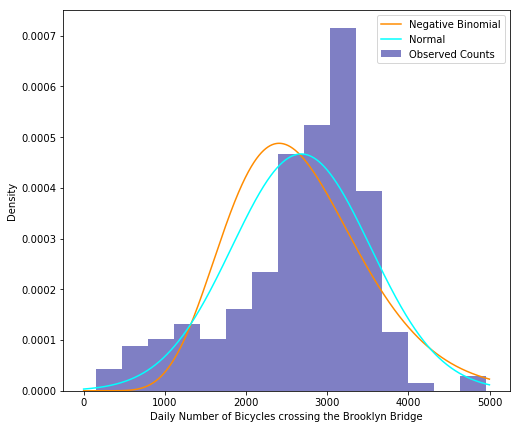

In [62]:
f, ax = plt.subplots(figsize = (8,7))

ax.hist(bikes['bb_count'],
        color='darkblue', 
        bins = 15, 
        alpha = 0.5, 
        normed = True, 
        label = 'Observed Counts')
ax.plot(nbinom.pmf(np.arange(0,5000), n = r, p = 1-p), 
        color = 'darkorange', 
        label = "Negative Binomial")
ax.plot(norm.pdf(np.arange(0,5000), loc = bikes['bb_count'].mean(), scale = bikes['bb_count'].std()), 
        color = 'cyan', 
        label = 'Normal')
ax.set_xlabel("Daily Number of Bicycles crossing the Brooklyn Bridge")
ax.set_ylabel("Density")
ax.legend();

The negative binomial model is not an exact fit for the bicycle count data, however we don't require it to be. We simply assume *errors* will follow a negative binomial distribution, the count of bicycle crossings can be a mix of distributions to be dealt with in the modelling phase to come.

The normal distribution is also often seen as a reasonable approximation for count data when the average value for count is high, the normal curve is also superimposed on the graph.

In general, the assumption that each 'event' (e.g. bicycle crossing the Brookyln Bridge) is independent is likely to be optimistic, but in the absence of any other information we'll make this assumption.

# A Linear Modelling Approach

We're going to use a linear modelling approach to model bicycle counts. We'll start with a simple linear model, looking at how the mean of bicycle counts differs according to whether it is a weekend day. The model is thus:

$$\mathrm{Bicycle\ Counts}_{i} = \beta_{0} + \beta_{1} \times \mathrm{Weekend\ Day} + \epsilon_{i}$$

Because weekend day is binary, we're effectively left with two equations:

1. $\mathrm{Bicycle\ Counts} = \beta_{0} + \beta_{1}$ : For Saturdays and Sundays
2. $\mathrm{Bicycle\ Counts} = \beta_{0}$: For weekdays.

We'll start off by estimating this a Gaussian linear model with an identity link - effectively a standard OLS regression.

In [95]:
model = sm.formula.glm(formula='bb_count~weekend',data=bikes, family = sm.families.Gaussian()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               bb_count   No. Observations:                  214
Model:                            GLM   Df Residuals:                      212
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      7.0789e+05
Method:                          IRLS   Log-Likelihood:                -1743.9
Date:                Mon, 02 Dec 2019   Deviance:                   1.5007e+08
Time:                        13:41:56   Pearson chi2:                 1.50e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2782.7171     68.243     40.776      0.000    2648.963    2916.472
weekend[T.True]  -354.3945    126.786     -2.795      0.005    -602.891    -105.899
===================================================================================
"""

Expressly using the `statsmodels` OLS model would produce some specific goodness of fit statistics relevant to linear regression, however the GLM approach is understandably more general. This means we don't get the $R^{2}$ statistic that we're familiar with, however this is straightforward to compute.

In [112]:
total_sum_squares = ((bikes['bb_count'] - bikes['bb_count'].mean())**2).sum()
regression_sum_squares = ((model.predict() - bikes['bb_count'].mean())**2).sum()
R_squared = regression_sum_squares/total_sum_squares
R_squared

0.035544913331642045

Here, the simple linear regression tells us that the mean number of bicycle trips taken on a weekday is the intercept ($\beta_{0}$) at 2,783 trips per day, while the mean number of bicycle trips on a weekend day is lower at 2,428 trips per day ($\beta_{0} + \beta_{1}$, or 2783 - 354).

This difference is statistically significant (p = 0.005), the difference is unlikely to have occured by chance (5 in 1000 chance), thus this appears to be a real difference.

However, the distinction between weekday and weekend only accounts for about 3.5% of the variance in cycling trips, so there is currently a lot missing from our model. As you can see below, the residuals don't fit a normal distribution as assumed.

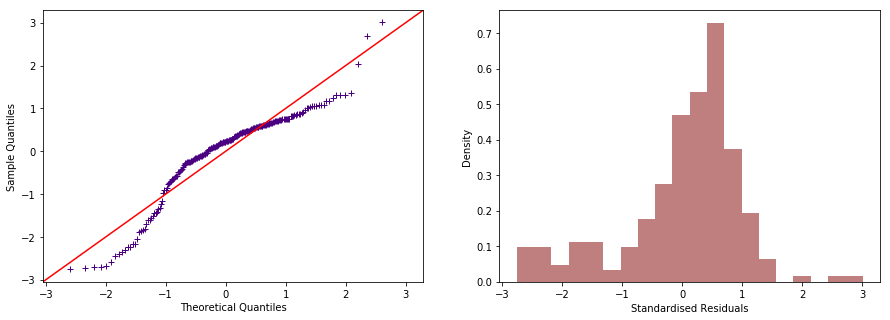

In [153]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# qq plot
sm.graphics.qqplot(data = model.resid_anscombe_scaled,
                   line = '45', 
                   color = 'indigo', 
                   marker = '+',
                   ax=ax1)

# Residual histogram
ax2.hist(model.resid_anscombe_scaled,
         bins = 20, 
         normed = True, 
         color = 'maroon', 
         alpha = 0.5)
ax2.set_xlabel("Standardised Residuals")
ax2.set_ylabel("Density");

# Implementing a Count Model in `statsmodels`

Statsmodels implements two approaches to fitting count models, either by specifying a [generalised linear model](https://www.statsmodels.org/stable/glm.html), or by expressly choosing a particular [discrete dependent variable model](https://www.statsmodels.org/stable/discretemod.html).

The main difference between these two approaches is that the discrete dependent variable regression models fit using maximum likelihood estimation (MLE), and the glms fit using iteratively reweighted least squares (IRLS). In maximum likelihood estimation the parameter values arrived at 'maximise the likelihood' that the process described by the model produced the data that were actually observed. While in least squares approaches we want to find the parameters of the regression line that minimise the total squared distance between the data and the line. The approaches effectively amount to the same thing for our purposes.

GLMs are a flexible tool, and well worth knowing, however, the discrete dependent variable submodule offers some exotic models that aren't currently available in the GLM submodule - notably poisson models for dealing with over/under-dispersion (generalised poisson) and count models for dealing with excess zeros ('zero-inflated' counts:  zero-inflated Poisson, Generalised Poisson and Negative Binomial). Generally, zero-inflated models first fit a logit or probit model to estimate zeros vs. counts, then fit a count model on the counts.

# Poisson Regression

We're first going to estimate a Poisson regression on our bicycle data, even though we suspect it of being a bad model due to over-dispersion of our data. Generally, it is good practice to start with a Poisson model and use it as a comparator for more complicated models like the negative binomial or generalised poisson models.

$$\mathrm{Bicycle\ Counts}_{i} \sim Poisson(\lambda_{i})$$

$$\log(\mathrm{Bicycle\ Counts_{i}}) = \beta_{0} + \beta_{1} \times \mathrm{Weekend\ Day} + \epsilon$$

So, we assume that our outcome (dependent) variable is Poisson distributed, therefore our model must form a link between the bounds of the linear model equation ($-\infty$ to $\infty$) and the bounds of the Poisson distribution ($0$ to $\infty$). Commonly, the link function chosen is the $log$, which does just that.

In [9]:
poisson_glm = sm.formula.glm(formula='bb_count~weekend',data=bikes, family = sm.families.Poisson()).fit()
poisson_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               bb_count   No. Observations:                  214
Model:                            GLM   Df Residuals:                      212
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34991.
Date:                Fri, 06 Dec 2019   Deviance:                       67917.
Time:                        10:35:58   Pearson chi2:                 5.63e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.9312      0.002   5158.154      0.000       7.928       7.934
weekend[T.True]    -0.1362      0.003    -45.393      0.000      -0.142      -0.130
===================================================================================
"""

The model parameters are now reported on the log scale owing to the link function, this means that we need to exponentiate if we want to see what the values of $\beta_{0}$ and $\beta_{1}$ are on the original scale of the data.

In [133]:
print(f"Estimated mean bicycles on a weekday: {np.exp(poisson_glm.params['Intercept']).round()}")
print(f"Estimated mean bicycles on a weekend: {np.exp(poisson_glm.params['Intercept'] + poisson_glm.params['weekend[T.True]']).round()}")     

Estimated mean bicycles on a weekday: 2783.0
Estimated mean bicycles on a weekend: 2428.0


Perhaps unsurprisingly, these averages are the same as with the linear model we fitted earlier.

The goodness of fit for the Poisson regression can be assessed with reference to the 'deviance', this is effectively a measure of badness-of-fit, with higher values indicating a worse fitting model. Basically, it is the difference between the 'fully saturated' (i.e. best possible model) and the model we have fit, ideally we a small difference to the best possible model, and hence low values are preferred.

But low compared to what? We also compute a 'null deviance' as the worst case scenario. The null deviance measures how well the outcome is predicted by the intercept alone - that is, just using the mean. Any model we fit should be a better model that the intercept only model.

In [143]:
print(f"Null deviance: {poisson_glm.null_deviance.round()}")
print(f"Deviance: {poisson_glm.deviance.round()}")

Null deviance: 70021.0
Deviance: 67917.0


The deviance has come down from the simple null model of the intercept, however it remains high relative to the null model and is a long, long way from the best possible model.

Similarly, the Pearson $\chi^{2}$ statistic is a test for the adequacy of the current fitted model, here, the test-statistic is very large suggesting considerable lack of fit against the null hypothesis of an adequate model. It effectively compares the observed counts in our data with the counts we expect or predict based on the model.

In [209]:
poisson_glm.pearson_chi2, chi2.sf(poisson_glm.pearson_chi2, poisson_glm.df_resid)

(56299.68359018001, 0.0)

It is also possible to estimate a *pseudo*-$R^{2}$ value, analogous to the $R^{2}$ in linear regression. This is because the null model provides a lower boundary for how badly a model can perform. Therefore, a pseudo $R^{2}$ is effectively the ratio between the fitted and null model.

$$R^{2} = 1 - \frac{\mathrm{LL(Fitted\ Model)}}{\mathrm{LL(Null\ Model)}}$$

In [227]:
pseudo_r_squared = 1 - poisson_glm.llf / poisson_glm.llnull
pseudo_r_squared

0.029193409823320193

The pseudo-$R^{2}$ value is 0.03, the current model explains very little of the variance in the outcome.

Now let's have a look at the residuals - variation in the data that cannot be explained by the model. Here, I've computed the adjusted residuals, which are the residuals normalised to unit variance. These can then be compared to the normal distribution to assess the presence of structure in the residuals.

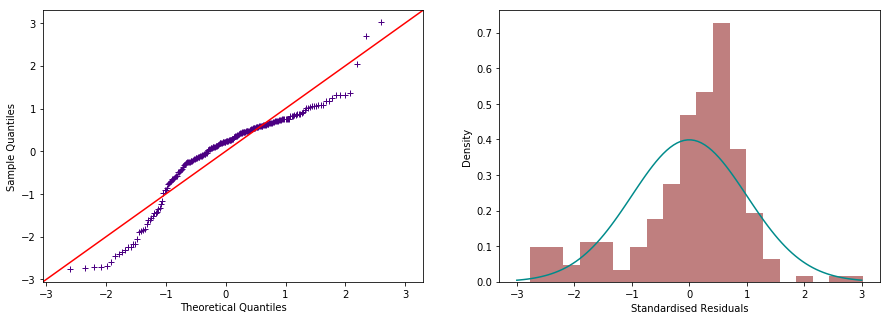

In [183]:
adjusted_residuals = (poisson_glm.resid_response/poisson_glm.resid_response.std())

f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# qq plot
sm.graphics.qqplot(data = adjusted_residuals,
                   line = '45', 
                   color = 'indigo', 
                   marker = '+',
                   ax=ax1)

# Residual histogram
ax2.hist(adjusted_residuals, 
         bins = 20, 
         normed = True, 
         color = 'maroon', 
         alpha = 0.5)
ax2.plot(np.linspace(-3,3,100), norm.pdf(np.linspace(-3,3,100), 0, 1), color = 'darkcyan')
ax2.set_xlabel("Standardised Residuals")
ax2.set_ylabel("Density");

In GLMs it is also common to use 'deviance residuals', these represent the square root of the contribution that each data point has to the overall deviance measure. This makes them analogous to the residuals in OLS regression.

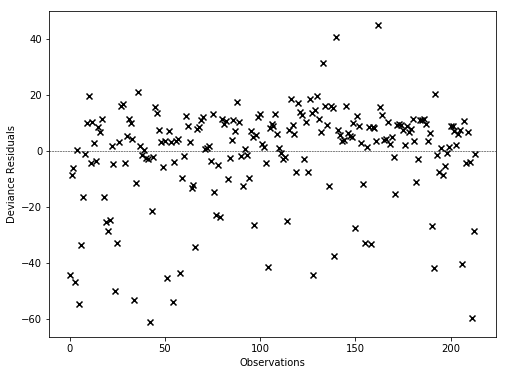

In [199]:
f, ax = plt.subplots(figsize=(8,6))

ax.scatter(np.arange(len(poisson_glm.resid_deviance)),poisson_glm.resid_deviance, marker = 'x', color = 'k')
ax.axhline(0, color = 'k', linestyle='dashed', linewidth = 0.5)
ax.set_ylabel("Deviance Residuals")
ax.set_xlabel("Observations");

It's clear from the plot of deviance residuals that there are a number of outlying counts that the current model is not doing a good job of estimating.

## What do my predictions look like?

We can also have a look at the quality of our predictions by plotting them against the observed values.

Usefully, when we predict values, statsmodels does all the exponentiation for us, so we don't have to worry about the logged coefficients!

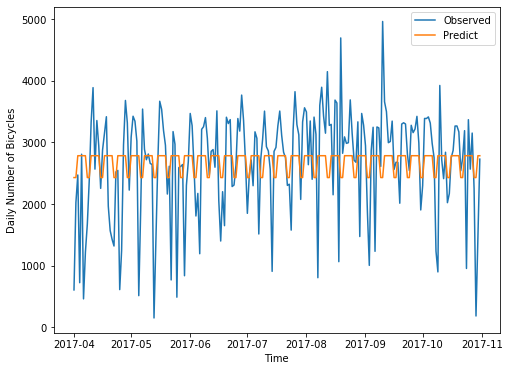

In [38]:
f, ax = plt.subplots(figsize=(8,6))

bikes['predict'] = poisson_glm.mu

# Time predictions plot
ax.plot(bikes['date'], bikes['bb_count'], label = 'Observed')
ax.plot(bikes['date'], bikes['predict'], label = 'Predicted')
ax.legend()
ax.set_ylabel("Daily Number of Bicycles")
ax.set_xlabel("Time");

The model currently only predicts means for weekdays and weekends, clearly there is more to account for if we want to make reasonable or useful predictions for cyclist behaviour on the Brooklyn Bridge.

In statsmodels, the same results can be achieved using the Poisson regression model from the discrete dependent variable submodule directly:

In [33]:
poisson_model = sm.formula.poisson(formula='bb_count~weekend',data=bikes).fit()
poisson_model.summary()

Optimization terminated successfully.
         Current function value: 163.507016
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:               bb_count   No. Observations:                  214
Model:                        Poisson   Df Residuals:                      212
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Dec 2019   Pseudo R-squ.:                 0.02919
Time:                        11:09:52   Log-Likelihood:                -34991.
converged:                       True   LL-Null:                       -36043.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.9312      0.002   5158.154      0.000       7.928       7.934
weekend[T.True]    -0.1362      0.003    -45.393      0.000      -0.142      -0.130
===================================================================================
"""

The model produces the same output as the GLM approach, however the output is a little different - we have the pseudo-$R^{2}$ value now instead of the deviance and the Pearson $\chi^{2}$ statistic. We also get a likelihood ratio test, telling us that the fitted model is an improvement over the intercept-only 'null' model.

## Is my Poisson model overdispersed?

As we've noted, the Poisson distribution assumes that the given mean is equal to the variance. If, in fact, our variance proves to be larger than the mean, we have overdispersed count data, which is inappropriate for the poisson model. Overdispersed data are inappropriate because they lead to an underestimation of the standard errors of our regression coefficients (these represent the precision or uncertainty of our coefficient estimates). Understated standard errors may lead us to believe that particular explanatory variables are significant in explaining our outcome of interest, when in reality they are not.

A simple check for overdispersion is the **dispersion statistic**, which is given by:  

$$\frac{\mathrm{Pearson}\ \chi^{2}}{\mathrm{Residual\ Degrees\ of\ Freedom}}$$

When the data is drawn from a Poisson distribution, this value should be approximately 1. A ratio less than 1 implies underdispersion (i.e. variance < mean), and a value more than 1 implies overdispersion (i.e. variance > mean).

Data that is underdispersed often arises dues to excess zeros, resulting from a separate data generating mechanism and requires a zero-inflated model which first fits a logit/probit model for zeroes vs. counts, and then a count model on the counts.

Data that is overdispersed can be modelled using a negative binomial model or a quasi-poisson approach.

In [34]:
dispersion_stat = poisson_glm.pearson_chi2 / poisson_glm.df_resid
dispersion_stat

265.56454523669817

Clearly from the dispersion statistic we're deep in overdispersion territory! Let's look now to fitting a negative binomial model to deal with this!

# Negative Binomial Regression

We expect out data will be better served by a negative binomial regression. However, specifying the negative binomial regression requires that we specify the value of a parameter called 'alpha' ($\alpha$). Alpha effectively scales the mean such that it reflects the variance of the data and hence accounts for overdispersion:

$$\sigma^{2} = \mu + \alpha \mu^{2}$$

Clearly, as $\alpha$ tends towards zero, the variance approaches the mean, and hence becomes a Poisson regression. Therefore, the poisson model is effectively nested within the negative binomial regression approach. You can check this if you like by fitting the negative binomial model with `alpha = 0.00000001`, this should yield the same fit as the poisson model we fitted earlier. (NB `alpha = 0` causes a `ZeroDivisionError`, hence the very small value used. 

It's not entirely obvious how we pick a good value for $\alpha$, however, in practice we can use a method called "auxiliary OLS regression without a constant" to implement the Cameron-Trivedi dispersion test. The meaning of 'auxiliary regression' is simply that we're using a regression to estimate something other than the primary model of interest (the count model), and the 'without a constant' part implies that we're not interested in fitting a line with an intercept.

The Cameron-Trivedi dispersion test is given by the regression equation:

$$\frac{(y_{i} - \mu_{i})^{2} - y_{i}}{\mu_{i}} = \alpha \times \mu_{i} + \epsilon_{i}$$

Where, the left-hand side of the equation is the response variable based on the fitted means $\mu_{i}$ from a Poisson regression model, and the value of $\alpha$ is essentially the OLS coefficient for the slope of the regression line.

In [80]:
# C-T test dependent variable
outcome = ((bikes['bb_count'] - poisson_glm.mu)**2 - bikes['bb_count'])/ poisson_glm.mu

# fit OLS model
aux_ols = sm.OLS(outcome, poisson_glm.mu).fit()

# get alpha
alpha = aux_ols.params['x1']
alpha

0.0969125962954623

Confidence intervals around this value of $\alpha$ are given with reference to the $t$ distribution.

In [89]:
lower_95, upper_95 = aux_ols.conf_int().values[0]
lower_95, upper_95

(0.0732622633756762, 0.12056292921524839)

Having estimated $\alpha$ to be 0.097 with a 95% confidence interval of (0.073, 0.121), we can specify the negative binomial regression:

In [90]:
nbin_glm = sm.formula.glm(formula='bb_count~weekend',
                          data=bikes, 
                          family = sm.families.NegativeBinomial(alpha = alpha)).fit()
nbin_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               bb_count   No. Observations:                  214
Model:                            GLM   Df Residuals:                      212
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1804.8
Date:                Fri, 06 Dec 2019   Deviance:                       369.65
Time:                        13:33:11   Pearson chi2:                     218.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.9312      0.025    313.521      0.000       7.882       7.981
weekend[T.True]    -0.1362      0.047     -2.898      0.004      -0.228      -0.044
===================================================================================
"""

In the negative binomial model, the estimates of $\beta_{0}$ and $\beta_{1}$ haven't really changed, what has changed are the standard errors and hence the intercepts. Now that we are accounting for the variance in the data, there is more uncertainty in the estimate of the true population parameters.

Similarly, the deviance and pearson $\chi^{2}$ values have come down, they're still high, but they're considerably lower than the equivalent Poisson model.

The model is a better model, but the simplicity of the binary predictor means that it doesn't actually differ in real-terms from the poisson model.

We have also dealt with the dispersion reaosnably effectively, the dispersion statistic is now quite close to 1:

In [92]:
dispersion_stat = nbin_glm.pearson_chi2 / nbin_glm.df_resid
dispersion_stat

1.0282202842690136

Note that it is also possible to fit the negative binomial regression using the discrete dependent variable regression submodule, in this case the value for $\alpha$ is computed as part of the maximum likelihood estimation and as a result it may be slightly different to the alpha we computed for our generalised linear model.

In [136]:
nb_mle = sm.formula.negativebinomial(formula='bb_count~weekend', data=bikes).fit()
nb_mle.summary()

Optimization terminated successfully.
         Current function value: 8.349478
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:               bb_count   No. Observations:                  214
Model:               NegativeBinomial   Df Residuals:                      212
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Dec 2019   Pseudo R-squ.:                0.001354
Time:                        14:25:06   Log-Likelihood:                -1786.8
converged:                       True   LL-Null:                       -1789.2
Covariance Type:            nonrobust   LLR p-value:                   0.02772
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.9312      0.033    241.759      0.000       7.867       7.995
weekend[T.True]    -0.1362      0.061     -2.235      0.025      -0.256      -0.017
alpha               0.1632      0.015     10.574      0.000       0.133       0.193
===================================================================================
"""

Here the estimated value of $\alpha$ is somewhat higher at 0.1632. We can see what this means for dispersion by calculating the Pearson residuals, squaring and summing to get the $\chi^{2}$ for this model.

In [138]:
pearson_residuals = ((bikes['bb_count'] - np.exp(nb_mle.fittedvalues)) / # residuals
                     np.sqrt(sm.families.NegativeBinomial(alpha = np.exp(nb_mle.lnalpha))
                             .variance(np.exp(nb_mle.fittedvalues)))) # sqrt of the variance of the fitted values.
                     
pearson_chisq = (pearson_residuals **2).sum()

dispersion_stat = pearson_chisq/ nb_mle.df_resid
dispersion_stat

0.6114410726585718

In this particular case, the dispersion stat comes out as 0.61, suggesting that the model is underdispersed. This may mean that the standard errors are too conservative (note they are larger than our GLM standard errors). As such, we will be less likely to accept explanatory variables as contributing to our model, potentially making type II errors (failure to reject a false null hypothesis).

In this case then, the glm seems to out-perform the standard negative binomial model.

# Exercise

Build a better model of bicycle trips over the Brookyln Bridge, consider:

1. Which variables are useful explanatory variables for your model - do some EDA and make choices.
2. Fit a Poisson model, check the intuition of the parameter estimates, the residuals and the model fit.
3. Try fitting a Negative Binomial model.

I've provided a couple of suggestions, example 1 is a multivariate negative binomial model, example 2 additionally includes an interaction term between temperature and rain.

In [240]:
# Start coding!
430.44

In [ ]:
# Example Solution 1
%load ./Solutions/glm_ex1.py

In [ ]:
# Example Solution 2
%load ./Solutions/glm_ex2.py